# Carbon Source Growth Matrix from Fitness Browser Database

**Purpose**: Create organism × carbon source growth/no-growth matrix

**Data Source**: Fitness Browser SQLite database (feba.db) with all 57 organisms from Deutschbauer lab

**Assumption**: 
- If organism has experiment data for a carbon source → **Growth = 1**
- If organism lacks data for a carbon source → **No Growth = 0**

**Output**: Binary matrix for metabolic model validation

**Last updated**: 2025-10-01

## Setup

In [23]:
import sqlite3
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

print("Imports successful")

Imports successful


## Configuration

In [24]:
# Database path
DB_PATH = Path("../downloads/feba.db")

# Output directory
OUTPUT_DIR = Path("results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Output files
MATRIX_FILE = OUTPUT_DIR / "carbon_source_growth_matrix.csv"
STATS_FILE = OUTPUT_DIR / "carbon_source_growth_matrix_stats.txt"
HEATMAP_FILE = OUTPUT_DIR / "carbon_source_growth_heatmap.png"

# Quality filters (optional - set to False to include all experiments)
APPLY_QUALITY_FILTERS = True
MIN_GMED = 50  # Minimum median reads per gene
MAX_MAD12 = 0.5  # Maximum median absolute difference

print(f"Configuration set")
print(f"  Database: {DB_PATH}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Quality filters: {APPLY_QUALITY_FILTERS}")

# Check database exists
if not DB_PATH.exists():
    print(f"\nERROR: Database not found at {DB_PATH}")
    print(f"Please ensure feba.db is in the downloads/ directory")
else:
    print(f"\nDatabase found: {DB_PATH.stat().st_size / 1e9:.1f} GB")

Configuration set
  Database: ../downloads/feba.db
  Output: results
  Quality filters: True

Database found: 8.6 GB


## Connect to Database

In [25]:
# Connect to database
print(f"Connecting to database: {DB_PATH}")
conn = sqlite3.connect(str(DB_PATH))
print("Connected")

Connecting to database: ../downloads/feba.db
Connected


## Explore Database Contents

In [26]:
# Count organisms
query = "SELECT COUNT(DISTINCT orgId) as n_organisms FROM Gene"
n_organisms = pd.read_sql_query(query, conn).iloc[0]['n_organisms']
print(f"Total organisms in database: {n_organisms}")

# Count experiments
query = "SELECT COUNT(DISTINCT expName) as n_experiments FROM Experiment"
n_experiments = pd.read_sql_query(query, conn).iloc[0]['n_experiments']
print(f"Total experiments in database: {n_experiments:,}")

# Count experiment groups
query = "SELECT expGroup, COUNT(*) as n FROM Experiment GROUP BY expGroup ORDER BY n DESC"
exp_groups = pd.read_sql_query(query, conn)
print(f"\nExperiment groups:")
print(exp_groups)

Total organisms in database: 57
Total experiments in database: 2,580

Experiment groups:
               expGroup     n
0                stress  3293
1         carbon source  2327
2       nitrogen source  1103
3              nutrient   269
4           nutrient t1   184
..                  ...   ...
65  r2a shaking control     2
66       r2a no shaking     2
67                          2
68                 bhis     1
69            alp richb     1

[70 rows x 2 columns]


## List All Organisms

In [27]:
# Get all organism IDs
query = """
SELECT DISTINCT orgId, COUNT(*) as n_genes
FROM Gene
WHERE type = 1  -- protein-coding genes only
GROUP BY orgId
ORDER BY orgId
"""
organisms_df = pd.read_sql_query(query, conn)

print(f"All {len(organisms_df)} organisms:")
print("="*70)
for idx, row in organisms_df.iterrows():
    print(f"  {row['orgId']:40s} {row['n_genes']:5,d} genes")

All 57 organisms:
  ANA3                                     4,360 genes
  BFirm                                    7,182 genes
  Bifido                                   1,960 genes
  Brev2                                    3,184 genes
  Btheta                                   4,816 genes
  Burk376                                  6,555 genes
  Burkholderia_OAS925                      6,501 genes
  Bvulgatus_CL09T03C04                     3,806 genes
  CL21                                     4,638 genes
  Caulo                                    3,886 genes
  Cola                                     4,625 genes
  Cup4G11                                  7,358 genes
  Dda3937                                  4,213 genes
  Ddia6719                                 4,110 genes
  DdiaME23                                 4,182 genes
  Dino                                     4,192 genes
  DvH                                      3,403 genes
  Dyella79                                 4,37

## Extract Carbon Source Experiments

In [28]:
# Build query
query = """
SELECT DISTINCT
    e.orgId,
    e.condition_1 as carbon_source,
    COUNT(DISTINCT e.expName) as n_experiments,
    AVG(e.gMed) as avg_gMed,
    AVG(e.mad12) as avg_mad12
FROM Experiment e
WHERE e.expGroup = 'carbon source'
"""

# Add quality filters if requested
if APPLY_QUALITY_FILTERS:
    query += f"""
    AND e.num > 0
    AND e.gMed >= {MIN_GMED}
    AND (e.mad12 IS NULL OR e.mad12 <= {MAX_MAD12})
    """

query += """
GROUP BY e.orgId, e.condition_1
ORDER BY e.orgId, e.condition_1
"""

print("Executing query...")
carbon_experiments = pd.read_sql_query(query, conn)

print(f"\n✓ Extracted carbon source data")
print(f"  Organism-carbon pairs: {len(carbon_experiments):,}")
print(f"  Unique organisms: {carbon_experiments['orgId'].nunique()}")
print(f"  Unique carbon sources: {carbon_experiments['carbon_source'].nunique()}")

if APPLY_QUALITY_FILTERS:
    print(f"\nQuality filters applied:")
    print(f"  gMed >= {MIN_GMED}")
    print(f"  mad12 <= {MAX_MAD12}")
else:
    print(f"\nNo quality filters applied")

Executing query...

✓ Extracted carbon source data
  Organism-carbon pairs: 1,089
  Unique organisms: 44
  Unique carbon sources: 198

Quality filters applied:
  gMed >= 50
  mad12 <= 0.5


## Create Growth Matrix

In [29]:
print("Creating growth matrix...")

# Create pivot table: organisms × carbon sources
growth_matrix = carbon_experiments.pivot_table(
    index='orgId',
    columns='carbon_source',
    values='n_experiments',
    aggfunc='sum',
    fill_value=0
)

# Get all organisms from database to ensure complete matrix
all_orgs = organisms_df['orgId'].unique()
growth_matrix = growth_matrix.reindex(all_orgs, fill_value=0)

# Convert to binary (1 = has data/growth, 0 = no data/no growth)
growth_matrix_binary = (growth_matrix > 0).astype(int)

print(f"\nGrowth matrix created")
print(f"  Shape: {growth_matrix_binary.shape[0]} organisms × {growth_matrix_binary.shape[1]} carbon sources")
print(f"  Total cells: {growth_matrix_binary.size:,}")
print(f"  Growth (1): {growth_matrix_binary.sum().sum():,} ({100 * growth_matrix_binary.sum().sum() / growth_matrix_binary.size:.1f}%)")
print(f"  No growth (0): {(growth_matrix_binary == 0).sum().sum():,} ({100 * (growth_matrix_binary == 0).sum().sum() / growth_matrix_binary.size:.1f}%)")

Creating growth matrix...

Growth matrix created
  Shape: 57 organisms × 198 carbon sources
  Total cells: 11,286
  Growth (1): 1,089 (9.6%)
  No growth (0): 10,197 (90.4%)


## Matrix Statistics

In [30]:
print("="*70)
print("CARBON SOURCE GROWTH MATRIX STATISTICS")
print("="*70)

# Overall
print(f"\nOverall:")
print(f"  Organisms: {len(growth_matrix_binary)}")
print(f"  Carbon sources: {len(growth_matrix_binary.columns)}")
print(f"  Total cells: {growth_matrix_binary.size:,}")
print(f"  Cells with growth: {growth_matrix_binary.sum().sum():,}")
print(f"  Coverage: {100 * growth_matrix_binary.sum().sum() / growth_matrix_binary.size:.2f}%")

# Per organism
per_org = growth_matrix_binary.sum(axis=1).sort_values(ascending=False)
print(f"\nPer Organism:")
print(f"  Most carbon sources tested: {per_org.index[0]} ({per_org.iloc[0]} sources)")
print(f"  Fewest carbon sources tested: {per_org.index[-1]} ({per_org.iloc[-1]} sources)")
print(f"  Median: {per_org.median():.1f} sources")
print(f"  Mean: {per_org.mean():.1f} sources")

# Per carbon source
per_carbon = growth_matrix_binary.sum(axis=0).sort_values(ascending=False)
print(f"\nPer Carbon Source:")
print(f"  Most organisms tested: {per_carbon.index[0]} ({per_carbon.iloc[0]} organisms)")
print(f"  Fewest organisms tested: {per_carbon.index[-1]} ({per_carbon.iloc[-1]} organisms)")
print(f"  Median: {per_carbon.median():.1f} organisms")
print(f"  Mean: {per_carbon.mean():.1f} organisms")

print("\n" + "="*70)

CARBON SOURCE GROWTH MATRIX STATISTICS

Overall:
  Organisms: 57
  Carbon sources: 198
  Total cells: 11,286
  Cells with growth: 1,089
  Coverage: 9.65%

Per Organism:
  Most carbon sources tested: Burkholderia_OAS925 (64 sources)
  Fewest carbon sources tested: Methanococcus_S2 (0 sources)
  Median: 17.0 sources
  Mean: 19.1 sources

Per Carbon Source:
  Most organisms tested: D-Glucose (31 organisms)
  Fewest organisms tested: polygalacturonic acid (1 organisms)
  Median: 3.0 organisms
  Mean: 5.5 organisms



## Top Carbon Sources by Coverage

In [31]:
# Show top 30 carbon sources
print("Top 30 carbon sources by number of organisms:")
print("="*70)
top_carbons = per_carbon.head(30)
for carbon, count in top_carbons.items():
    pct = 100 * count / len(growth_matrix_binary)
    print(f"  {carbon:45s} {int(count):3d} organisms ({pct:5.1f}%)")

Top 30 carbon sources by number of organisms:
  D-Glucose                                      31 organisms ( 54.4%)
  Sodium D,L-Lactate                             26 organisms ( 45.6%)
  Sodium pyruvate                                26 organisms ( 45.6%)
  Sodium succinate dibasic hexahydrate           25 organisms ( 43.9%)
  Sodium L-Lactate                               25 organisms ( 43.9%)
  L-Glutamine                                    23 organisms ( 40.4%)
  L-Malic acid disodium salt monohydrate         23 organisms ( 40.4%)
  D-Fructose                                     22 organisms ( 38.6%)
  casamino acids                                 21 organisms ( 36.8%)
  Sodium D-Lactate                               21 organisms ( 36.8%)
  Glycerol                                       21 organisms ( 36.8%)
  a-Ketoglutaric acid disodium salt hydrate      21 organisms ( 36.8%)
  D-Mannose                                      19 organisms ( 33.3%)
  D-Maltose monohydrate        

## Organisms by Carbon Source Coverage

In [32]:
# Show all organisms with their carbon source counts
print("All organisms ranked by number of carbon sources tested:")
print("="*70)
for org, count in per_org.items():
    pct = 100 * count / len(growth_matrix_binary.columns)
    print(f"  {org:40s} {int(count):3d} carbon sources ({pct:5.1f}%)")

All organisms ranked by number of carbon sources tested:
  Burkholderia_OAS925                       64 carbon sources ( 32.3%)
  Putida                                    54 carbon sources ( 27.3%)
  WCS417                                    51 carbon sources ( 25.8%)
  BFirm                                     49 carbon sources ( 24.7%)
  Btheta                                    47 carbon sources ( 23.7%)
  Variovorax_OAS795                         47 carbon sources ( 23.7%)
  pseudo3_N2E3                              46 carbon sources ( 23.2%)
  pseudo5_N2C3_1                            45 carbon sources ( 22.7%)
  Koxy                                      41 carbon sources ( 20.7%)
  pseudo1_N1B4                              39 carbon sources ( 19.7%)
  Bifido                                    36 carbon sources ( 18.2%)
  pseudo6_N2E2                              36 carbon sources ( 18.2%)
  Cup4G11                                   35 carbon sources ( 17.7%)
  Smeli             

## Save Matrix

In [33]:
# Save binary matrix
print(f"Saving matrix to: {MATRIX_FILE}")
growth_matrix_binary.to_csv(MATRIX_FILE)
print(f"Saved")

# Save statistics
print(f"\nSaving statistics to: {STATS_FILE}")
with open(STATS_FILE, 'w') as f:
    f.write("Carbon Source Growth Matrix Statistics\n")
    f.write("="*70 + "\n\n")
    f.write(f"Generated: {pd.Timestamp.now()}\n")
    f.write(f"Database: {DB_PATH}\n\n")
    
    f.write("Overall:\n")
    f.write(f"  Organisms: {len(growth_matrix_binary)}\n")
    f.write(f"  Carbon sources: {len(growth_matrix_binary.columns)}\n")
    f.write(f"  Total cells: {growth_matrix_binary.size:,}\n")
    f.write(f"  Cells with growth: {growth_matrix_binary.sum().sum():,}\n")
    f.write(f"  Coverage: {100 * growth_matrix_binary.sum().sum() / growth_matrix_binary.size:.2f}%\n\n")
    
    f.write("Per Organism:\n")
    f.write(f"  Max carbon sources: {per_org.max():.0f}\n")
    f.write(f"  Min carbon sources: {per_org.min():.0f}\n")
    f.write(f"  Median: {per_org.median():.1f}\n")
    f.write(f"  Mean: {per_org.mean():.1f}\n\n")
    
    f.write("Per Carbon Source:\n")
    f.write(f"  Max organisms: {per_carbon.max():.0f}\n")
    f.write(f"  Min organisms: {per_carbon.min():.0f}\n")
    f.write(f"  Median: {per_carbon.median():.1f}\n")
    f.write(f"  Mean: {per_carbon.mean():.1f}\n\n")
    
    f.write("Assumption:\n")
    f.write("  1 = Organism has data for carbon source (GROWTH)\n")
    f.write("  0 = Organism lacks data for carbon source (NO GROWTH)\n\n")
    
    if APPLY_QUALITY_FILTERS:
        f.write("Quality Filters Applied:\n")
        f.write(f"  gMed >= {MIN_GMED}\n")
        f.write(f"  mad12 <= {MAX_MAD12}\n")
    else:
        f.write("Quality Filters: None\n")

print(f"Saved")

Saving matrix to: results/carbon_source_growth_matrix.csv
Saved

Saving statistics to: results/carbon_source_growth_matrix_stats.txt
Saved


## Visualize Matrix as Heatmap

Saving heatmap to: results/carbon_source_growth_heatmap.png
Saved


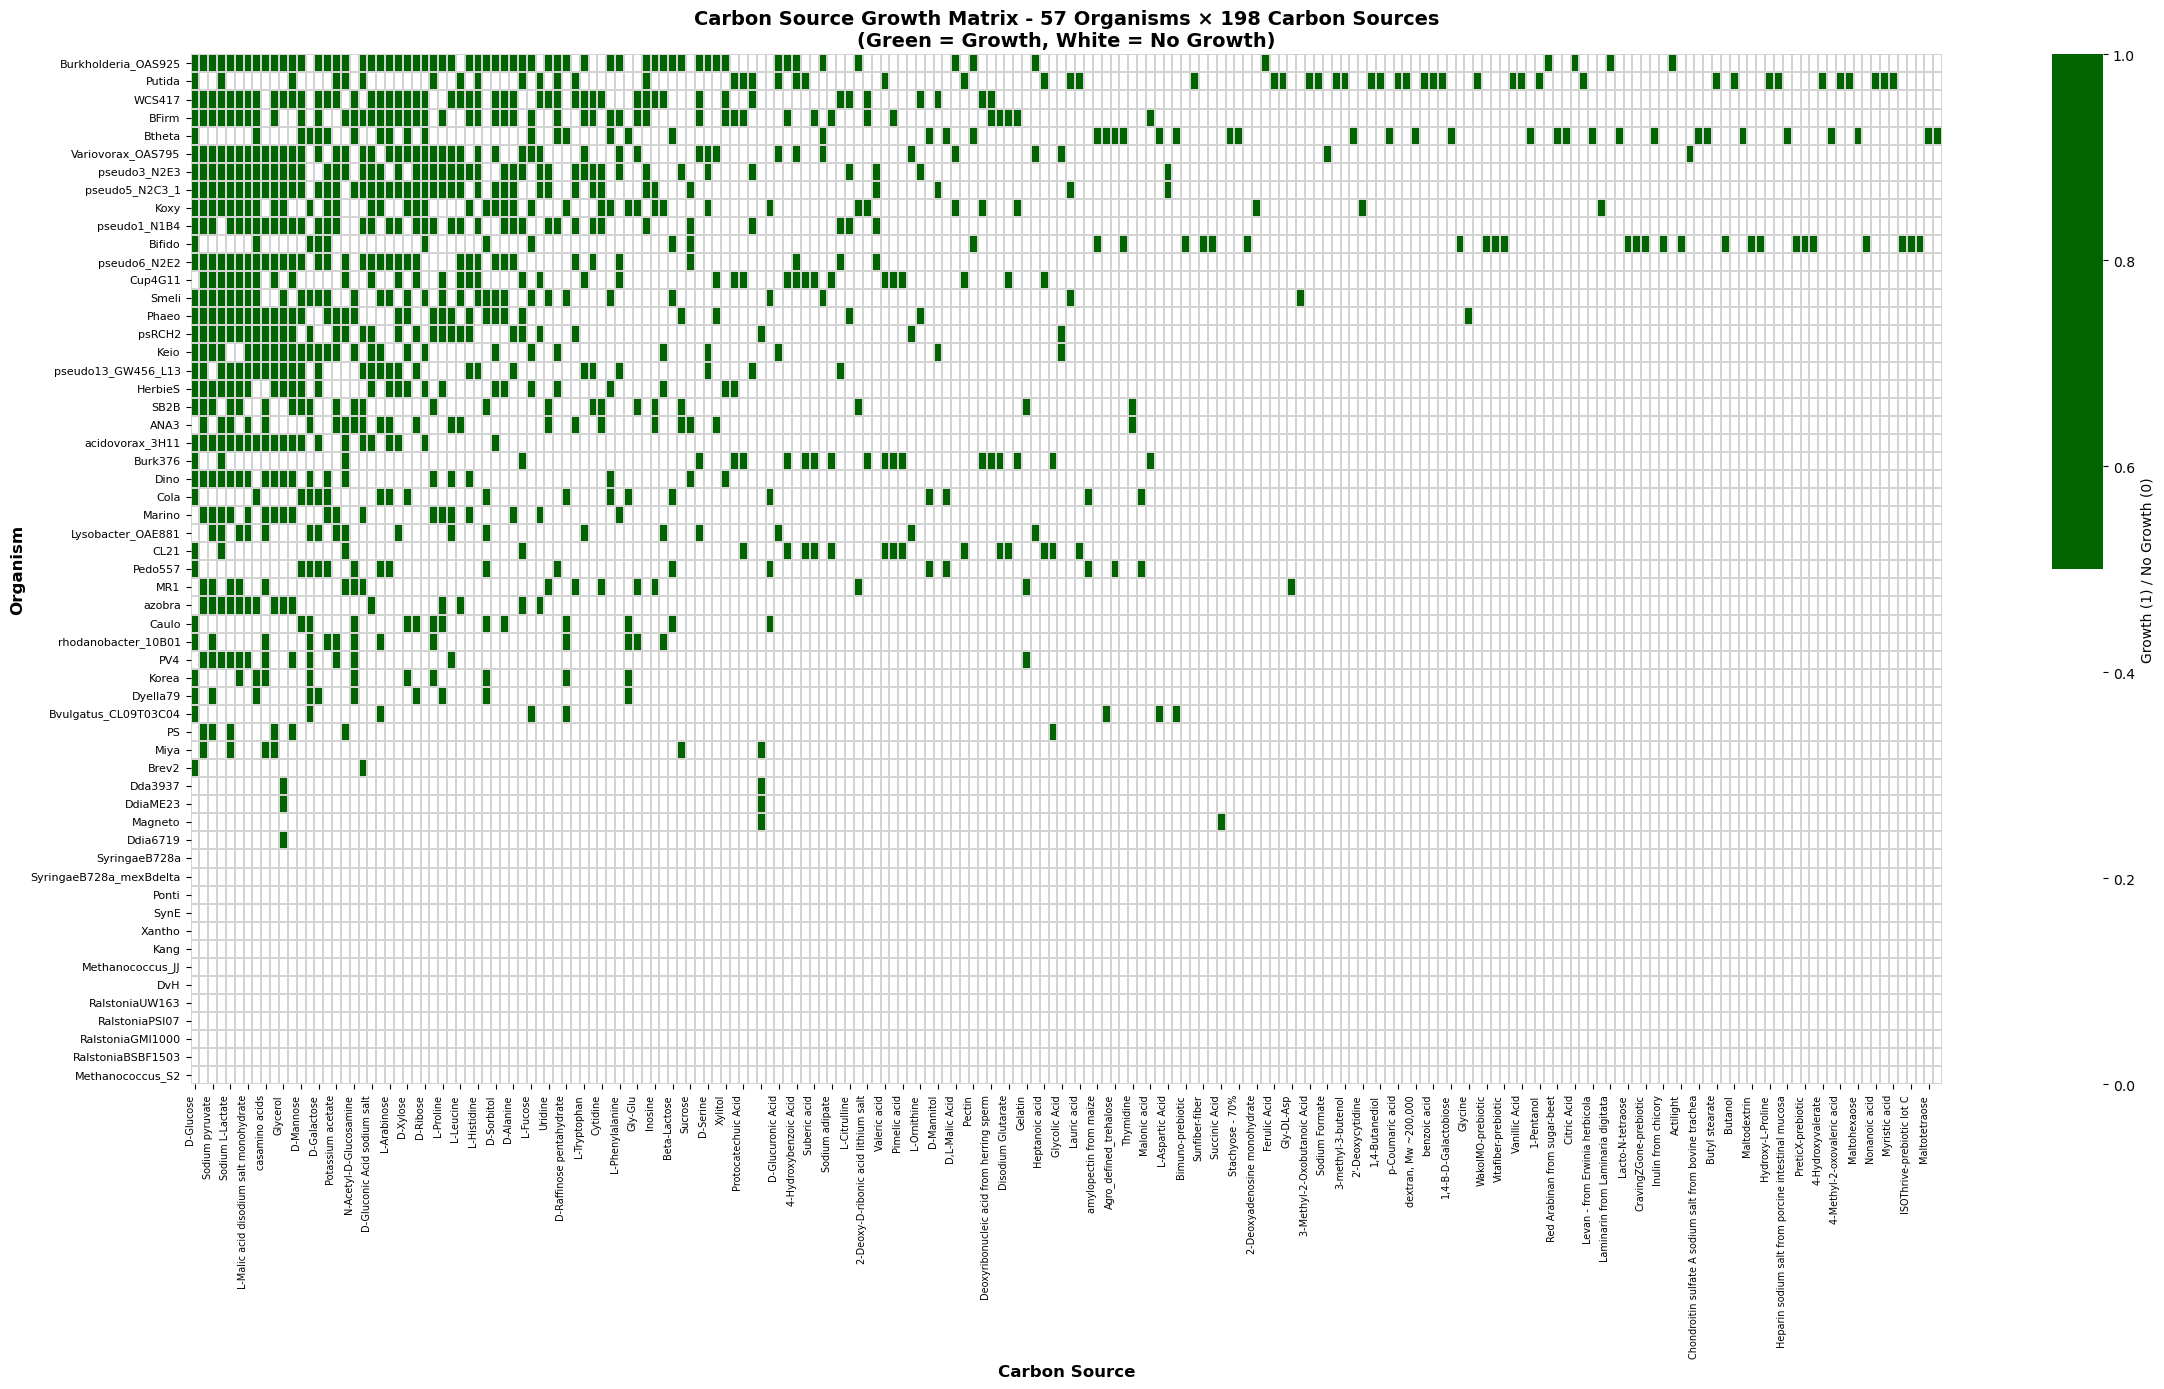

In [34]:
# Create heatmap
fig, ax = plt.subplots(figsize=(24, 14))

# Sort by coverage for better visualization
sorted_organisms = per_org.index
sorted_carbons = per_carbon.index

# Reorder matrix
matrix_sorted = growth_matrix_binary.loc[sorted_organisms, sorted_carbons]

# Plot heatmap
sns.heatmap(
    matrix_sorted,
    cmap=['white', 'darkgreen'],
    cbar_kws={'label': 'Growth (1) / No Growth (0)'},
    linewidths=0.3,
    linecolor='lightgray',
    ax=ax
)

ax.set_xlabel('Carbon Source', fontsize=12, fontweight='bold')
ax.set_ylabel('Organism', fontsize=12, fontweight='bold')
ax.set_title(f'Carbon Source Growth Matrix - {len(growth_matrix_binary)} Organisms × {len(growth_matrix_binary.columns)} Carbon Sources\n(Green = Growth, White = No Growth)', 
             fontsize=14, fontweight='bold')

plt.xticks(rotation=90, ha='right', fontsize=7)
plt.yticks(fontsize=8)
plt.tight_layout()

# Save
print(f"Saving heatmap to: {HEATMAP_FILE}")
plt.savefig(HEATMAP_FILE, dpi=300, bbox_inches='tight')
print(f"Saved")

plt.show()

## Inspect Specific Examples

In [35]:
# Example: Which organisms grow on glucose?
glucose_cols = [col for col in growth_matrix_binary.columns if 'glucose' in col.lower()]

if glucose_cols:
    print("Glucose-related carbon sources found:")
    for col in glucose_cols:
        print(f"  {col}")
    
    # Use first glucose column
    glucose_col = glucose_cols[0]
    glucose_growth = growth_matrix_binary[glucose_col]
    
    print(f"\n{glucose_col} growth:")
    print(f"  Total organisms: {len(glucose_growth)}")
    print(f"  Organisms with growth (1): {glucose_growth.sum()}")
    print(f"  Organisms without data (0): {(glucose_growth == 0).sum()}")
    print(f"\nOrganisms that GROW on {glucose_col}:")
    for org in glucose_growth[glucose_growth == 1].index:
        print(f"    {org}")
    print(f"\nOrganisms with NO DATA (assumed no growth) on {glucose_col}:")
    for org in glucose_growth[glucose_growth == 0].index:
        print(f"    {org}")
else:
    print("No glucose carbon sources found")

Glucose-related carbon sources found:
  6-O-Acetyl-D-glucose
  D-Glucose
  D-Glucose-6-Phosphate sodium salt

6-O-Acetyl-D-glucose growth:
  Total organisms: 57
  Organisms with growth (1): 1
  Organisms without data (0): 56

Organisms that GROW on 6-O-Acetyl-D-glucose:
    Btheta

Organisms with NO DATA (assumed no growth) on 6-O-Acetyl-D-glucose:
    ANA3
    BFirm
    Bifido
    Brev2
    Burk376
    Burkholderia_OAS925
    Bvulgatus_CL09T03C04
    CL21
    Caulo
    Cola
    Cup4G11
    Dda3937
    Ddia6719
    DdiaME23
    Dino
    DvH
    Dyella79
    HerbieS
    Kang
    Keio
    Korea
    Koxy
    Lysobacter_OAE881
    MR1
    Magneto
    Marino
    Methanococcus_JJ
    Methanococcus_S2
    Miya
    PS
    PV4
    Pedo557
    Phaeo
    Ponti
    Putida
    RalstoniaBSBF1503
    RalstoniaGMI1000
    RalstoniaPSI07
    RalstoniaUW163
    SB2B
    Smeli
    SynE
    SyringaeB728a
    SyringaeB728a_mexBdelta
    Variovorax_OAS795
    WCS417
    Xantho
    acidovorax_3H11
    azobra

## Close Database Connection

In [36]:
conn.close()
print("Database connection closed")

Database connection closed


## Summary

In [37]:
print("="*70)
print("SUMMARY")
print("="*70)
print(f"\nCarbon source growth matrix created from full database")
print(f"\nFiles created:")
print(f"  {MATRIX_FILE}")
print(f"  {STATS_FILE}")
print(f"  {HEATMAP_FILE}")
print(f"\nMatrix details:")
print(f"  {len(growth_matrix_binary)} organisms (ALL organisms from database)")
print(f"  {len(growth_matrix_binary.columns)} carbon sources")
print(f"  {100 * growth_matrix_binary.sum().sum() / growth_matrix_binary.size:.1f}% coverage")
print(f"\nInterpretation:")
print(f"  1 = Organism has data (GROWTH assumed)")
print(f"  0 = Organism lacks data (NO GROWTH assumed)")
print(f"\nNext steps:")
print(f"  1. Build metabolic models for {len(growth_matrix_binary)} organisms")
print(f"  2. Simulate growth on {len(growth_matrix_binary.columns)} carbon sources")
print(f"  3. Compare in silico predictions vs experimental matrix")
print(f"  4. Generate confusion matrix")
print("\n" + "="*70)

SUMMARY

Carbon source growth matrix created from full database

Files created:
  results/carbon_source_growth_matrix.csv
  results/carbon_source_growth_matrix_stats.txt
  results/carbon_source_growth_heatmap.png

Matrix details:
  57 organisms (ALL organisms from database)
  198 carbon sources
  9.6% coverage

Interpretation:
  1 = Organism has data (GROWTH assumed)
  0 = Organism lacks data (NO GROWTH assumed)

Next steps:
  1. Build metabolic models for 57 organisms
  2. Simulate growth on 198 carbon sources
  3. Compare in silico predictions vs experimental matrix
  4. Generate confusion matrix

